Variational Autoencoder
===

This is a code for a variational autoencoder type of generative model in the field of machine learning that is used to efficiently learn and represent the underlying data structure in a latent space. Unlike traditional autoencoders, the VAE introduces a probabilistic component that allows you to capture uncertainty in data generation.

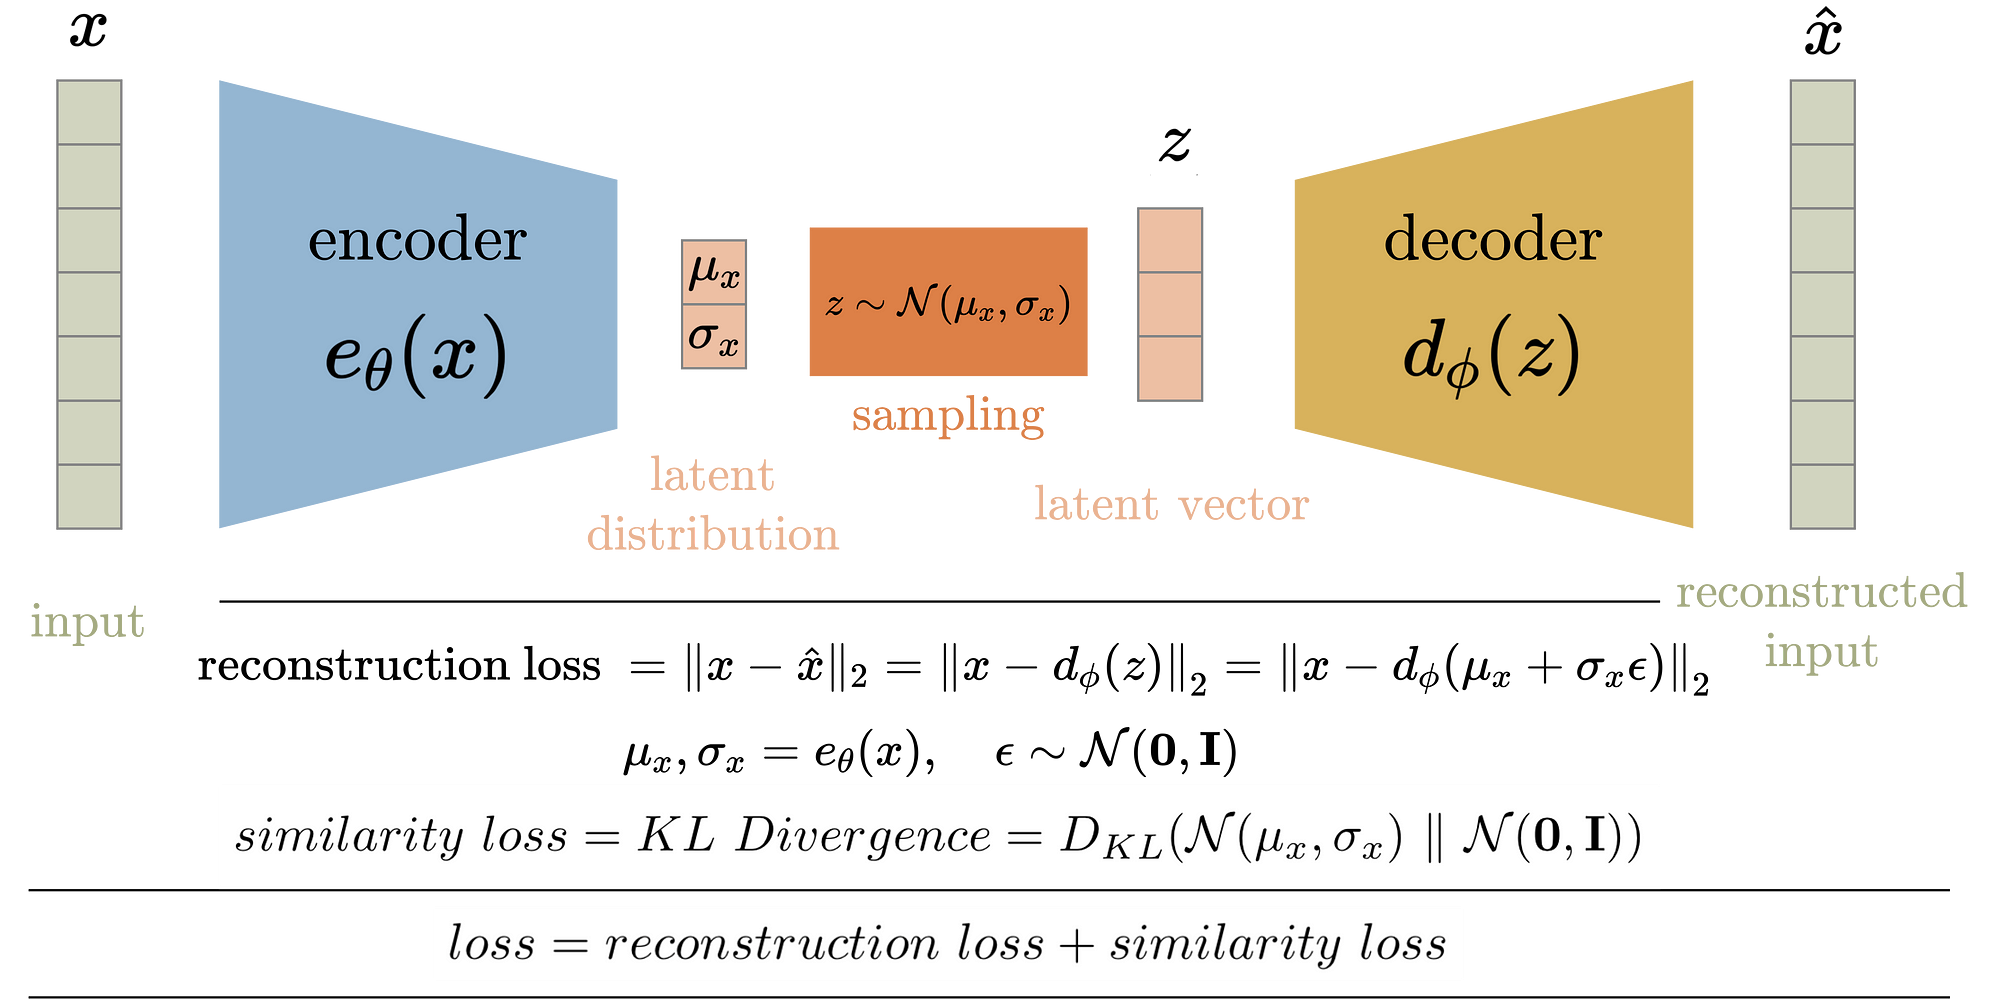


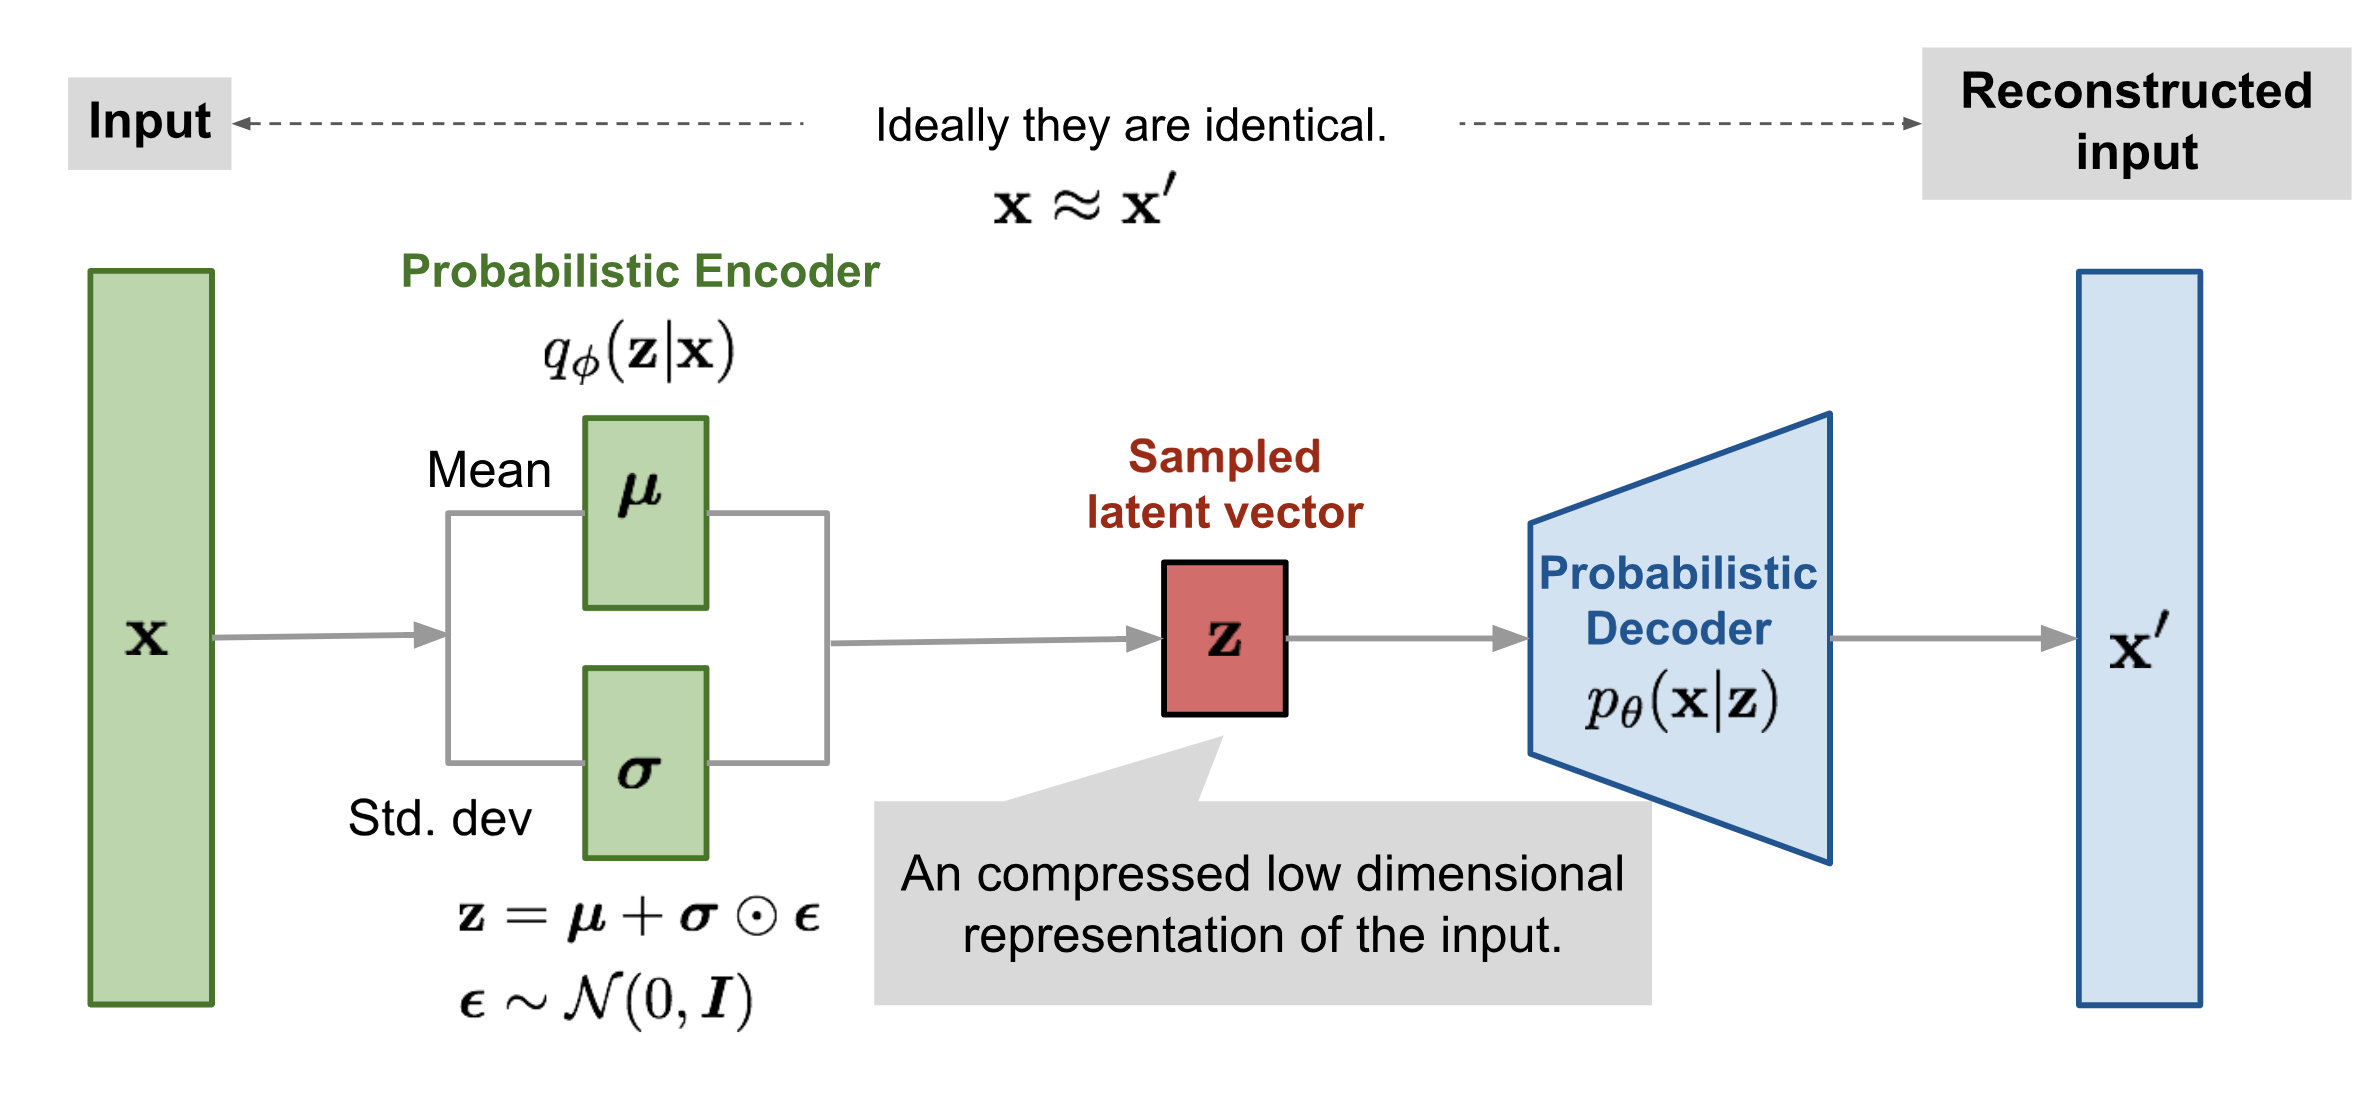

In a simple way, this can be thought of as a compressing mlp, where upon reaching the latent space, we try to find the mean and standard deviation of the "real" distribution and then sample a sample over that distribution. However, sampling directly from this distribution would not be differentiable, so reparameterization is used which introduces a random variable $\epsilon$ taken from a standard distribution $N(0,1)$. Then this epsilon variable is scaled by the standard deviation and added to the mean to obtain the latent sample $z=\mu + \epsilon \dot \sigma$.
With this trick you already have differentiability and you can now calculate gradients with respect to $\sigma$ and $\mu$ and thus update encoder and decoder weights.

In a way this $\epsilon$ would work with a regularizer since it is a random number that comes from a $N(0,1)$ distribution. Once the model is trained, after the decoder, it passes only the mean $\mu$ and thereby generates the sample z in latent space ($z=\mu$). It is as if for each sample we could find its latent distribution that has the form of a standard distribution and we sampled the mean (most probable) and that would be z.

These models, once trained, can serve as generative models, since once the VAE has learned the latent distributions $q_\phi (Z\vert X)$ it can generate new samples by taking random samples from that latent distribution. The decoder is responsible for sampling those random samples back to the observation space, that sample resembles the original training data.

Imports

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchmetrics import Accuracy, Precision, Recall
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

#%matplotlib inline

MNIST

In [30]:
train_transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=700, shuffle=True)

Let's see some mnist images

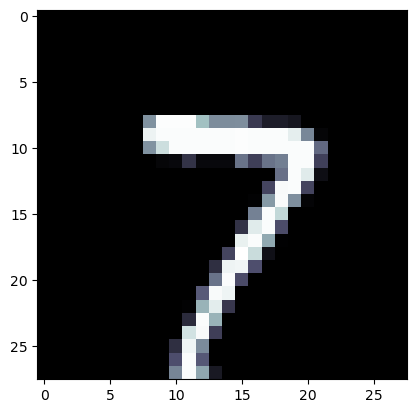

In [31]:
dataiter = iter(trainloader)
images, labels = dataiter.__next__()
images.shape
plt.imshow(images[32].squeeze().numpy(), cmap='bone')

Define VAE Class

In [32]:
class Net(nn.Module):
    def __init__(self, num_latent):
        super().__init__()
        self.num_latent = num_latent
        
        #######----------------------Encoder-------------------------------########
        #Layers para el encoder usando convoluciones
        self.encoder = nn.Sequential(nn.Conv2d(1, 3, 3, padding=1),
                                     nn.MaxPool2d(2, 2),
                                     nn.BatchNorm2d(3),
                                     nn.Conv2d(3, 16, 3, padding=1),
                                     nn.MaxPool2d(2, 2),
                                     nn.BatchNorm2d(16),
                                     nn.Conv2d(16, 16, 3, padding=1))
        
        #dos layers fully connected  y luego dos layers para obtener la media y el logaritmo de la varianza
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.mean = nn.Linear(128, num_latent)
        self.var = nn.Linear(128, num_latent)
        
        #######------------------------Decoder----------------------------########
        #capas fully connected para expandir el latent space
        self.expand = nn.Linear(num_latent, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 784)

        #layers para el decoder usando convoluciones para reconstruir la imagen
        self.decoder = nn.Sequential(nn.ConvTranspose2d(16, 16, 3, padding=1),
                                     nn.BatchNorm2d(16),
                                     nn.ConvTranspose2d(16, 3, 8),
                                     nn.BatchNorm2d(3),
                                     nn.ConvTranspose2d(3, 1, 15))
        
    def enc_func(self, x):
        #se regresara el logvar (logaritmo de la varianza) y la media (\mu) de la red
        x = self.encoder(x)
        x = x.view([-1, 784])
        x = F.dropout2d(self.fc1(x), 0.5) #dropout para evitar overfitting
        x = self.fc2(x)

        #Importante: el mismo valor de x se usa para calcular la media y la varianza
        mean = self.mean(x)
        logvar = self.var(x)
        return mean, logvar
    
    def dec_func(self, z):
        #recibe estado latente y regresa la imagen reconstruida
        z = self.expand(z)
        z = F.dropout2d(self.fc3(z), 0.5)
        z = self.fc4(z)
        z = z.view([-1, 16, 7, 7])
        
        out = self.decoder(z)
        out = F.sigmoid(out)
        return out
    
    #Funcion para obtener el estado latente, durante el entrenamiento se agrega ruido (\epsilon de una distribucion normal) para así poder usar el truco de reparametrizacion
    # y poder calcular el gradiente de la red respecto a la varianza y la media.
    # En el caso de la inferencia se regresa la media de esa distribucion aproximada
    def get_hidden(self, mean, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)   # lo que sale de red de la varianza es el logaritmo de la varianza. Se usa la relacion std=sqrt(var) 
            noise = torch.randn_like(mean)   #obtenemos ruido o el epsilon de la distribucion normal
            return noise.mul(std).add_(mean)    #se regresa el estado latente z=mu+std*epsilon
        else:
            return mean
    
    def forward(self, x):
        mean, logvar = self.enc_func(x) #se obtiene la media y la varianza
        z = self.get_hidden(mean, logvar)   #se obtiene el estado latente
        out = self.dec_func(z)  #se reconstruye la imagen
        return out, mean, logvar
    

    def generate_images_from_latent(self, n, digit_size, device):
        self.eval()
        
        with torch.no_grad():
            # Generate new images by sampling from the latent space
            z_samples = torch.randn(n * n, self.num_latent).to(device)
            generated_images = self.dec_func(z_samples)
            
        figure = np.zeros((digit_size * n, digit_size * n))
        
        for i in range(n):
            for j in range(n):
                digit = generated_images[i * n + j].squeeze().cpu().detach().numpy()
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit
                
        plt.figure(figsize=(10, 10))
        plt.imshow(figure, cmap='bone')
        plt.show()

In [33]:
def VAE_loss(out, target, mean, logvar):
    category1 = nn.BCELoss()    #Binary cross entropy loss
    bce_loss = category1(out, target)   # esto es el error de reconstruccion
    
    #definimos un factor de escala para el KL divergence loss, para que sea comparable con el error de reconstruccion, este factor de escala es el numero de elementos en la imagen
    scaling_factor = out.shape[0]*out.shape[1]*out.shape[2]*out.shape[3]
    
    #the KL divergence loss que dice que tanto se parecen dos distribuciones, en este caso la distribucion de los datos y la distribucion normal D_kl(N(mean,var)||N(0,1))
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_loss = -0.5 * torch.sum(1 + logvar - mean**2 - torch.exp(logvar))
    kl_loss /= scaling_factor
    
    return bce_loss + kl_loss   # esto es el error total osea Total Error = Reconstruction Error + KL Divergence Loss

Training

In [34]:
def train(trainloader, iters, model, device, optimizer, print_every):
    counter = 0
    for i in range(iters):
        model.train()
        model.to(device)
        for images, _ in trainloader:
            images = images.to(device)
            optimizer.zero_grad()
            out, mean, logvar = model(images)
            loss = VAE_loss(out, images, mean, logvar)
            loss.backward()
            optimizer.step()
            
        if(counter % print_every == 0):
            model.eval()
            n = 10  # figure with 20x20 digits
            digit_size = 28
            figure = np.zeros((digit_size * n, digit_size * n))

            # Construct grid of latent variable values
            grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
            grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

            counter = 0
            # decode for each square in the grid
            for i, yi in enumerate(grid_x):
                for j, xi in enumerate(grid_y):
                    digit = out[counter].squeeze().cpu().detach().numpy()
                    figure[i * digit_size: (i + 1) * digit_size,
                           j * digit_size: (j + 1) * digit_size] = digit
                    counter += 1

            plt.figure(figsize=(10, 10))
            plt.imshow(figure, cmap='bone')
            plt.show()  

        counter += 1

cuda


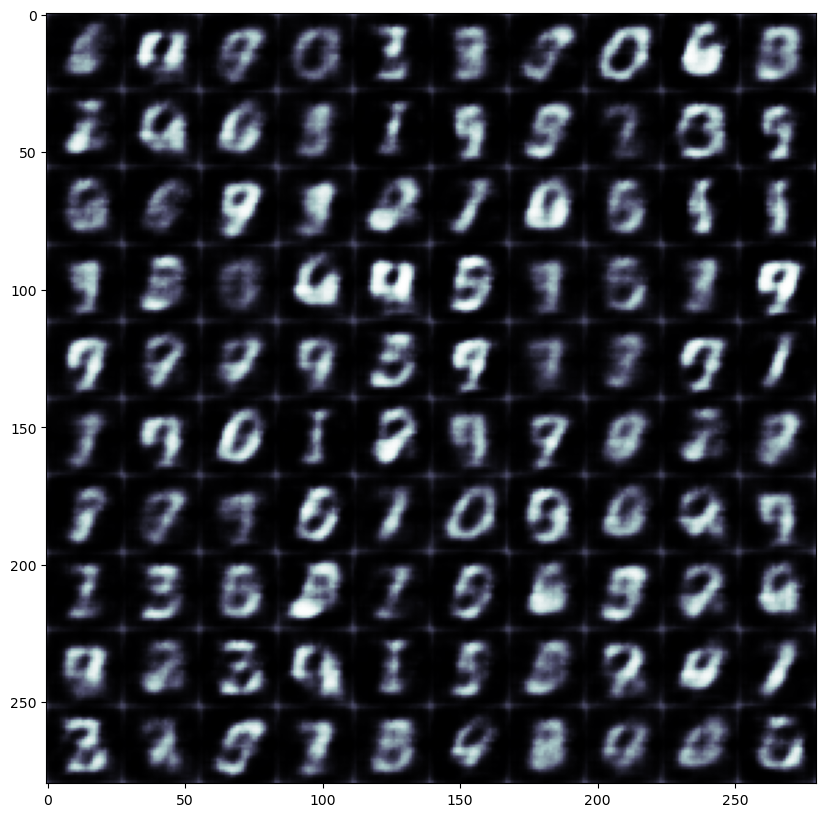

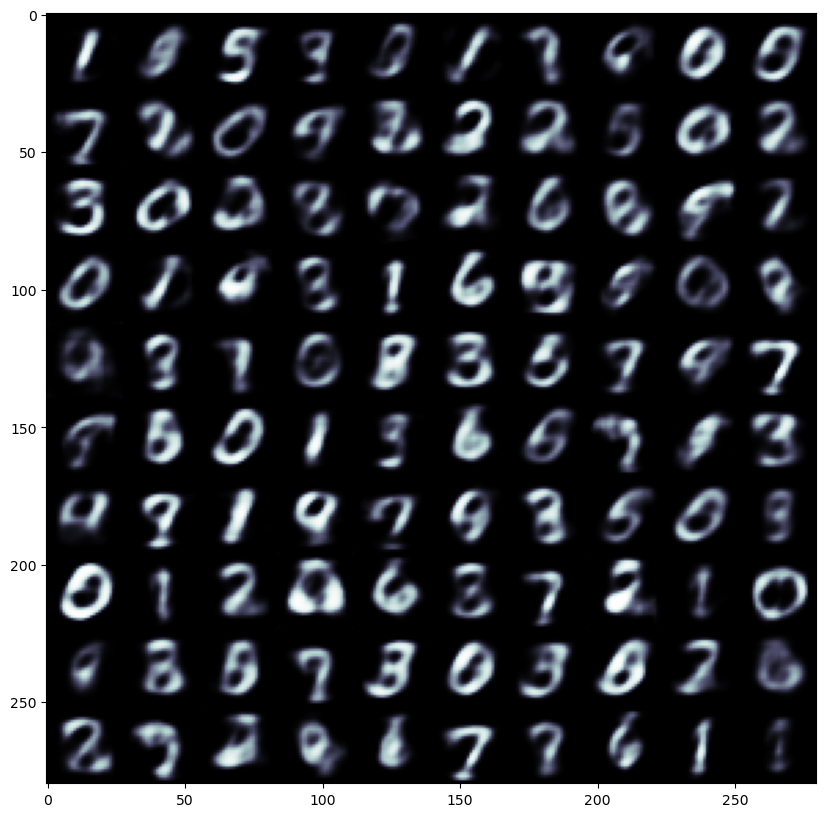

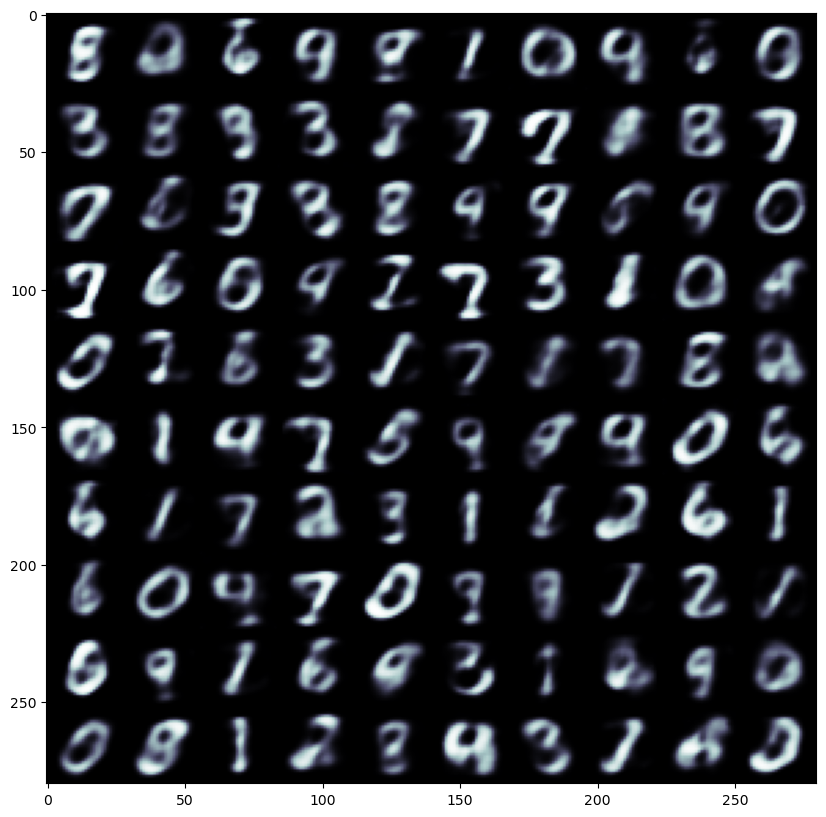

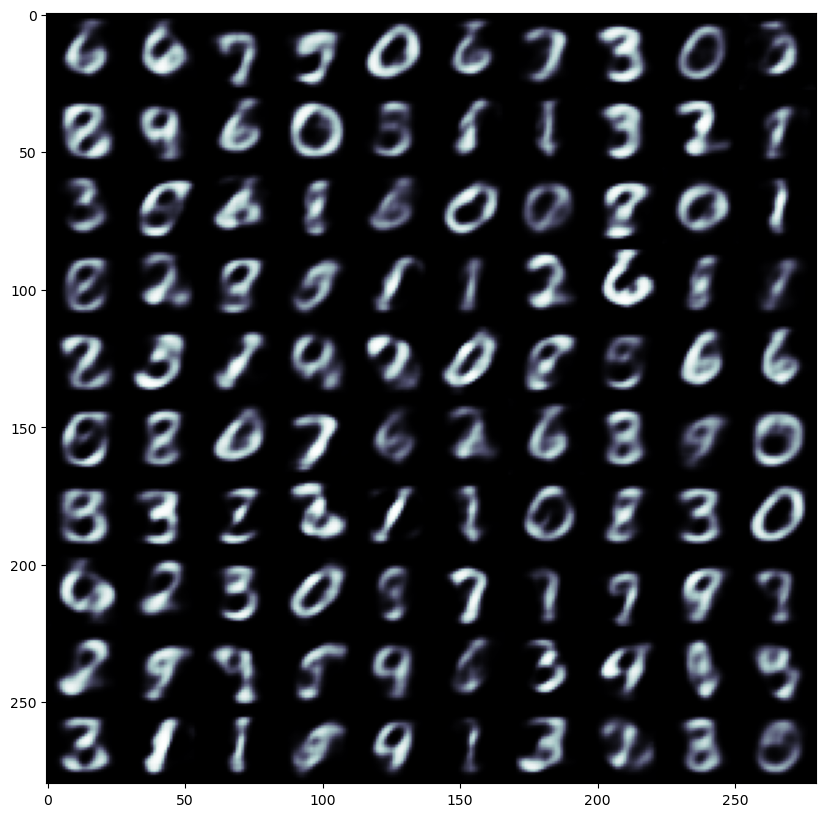

In [36]:
iters = 200
num_latent = 40
print_every = 50    #print after every 5 iterations
model = Net(num_latent)

device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=2e-3)

train(trainloader, iters, model, device, optimizer, print_every)
torch.save(model.state_dict(), 'vae_model.pth')

load pretrained weights and use the model to generate new images

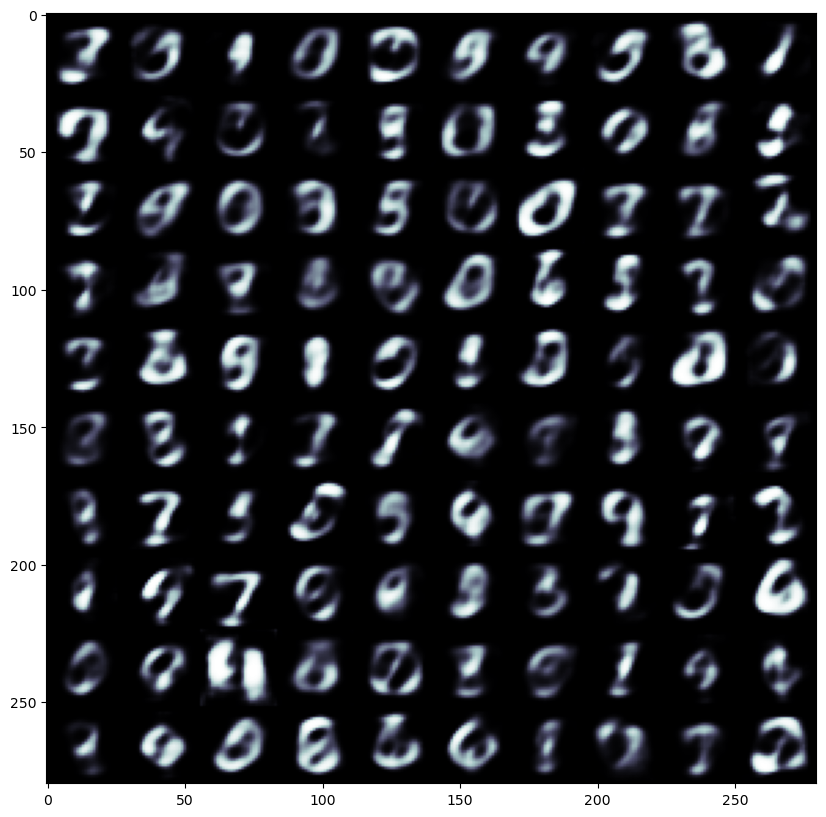

In [38]:
# Crear una instancia del modelo
#vae = Net(num_latent=50)  # Reemplaza 'your_num_latent_value' con el valor correcto
num_latent=40
vae = Net(num_latent).to(device)

# Cargar los parámetros del modelo entrenado
vae.load_state_dict(torch.load('vae_model.pth'))
vae.eval()

# Llamar a la función para generar imágenes
n = 10  # Número de imágenes a generar
digit_size = 28  # Tamaño de cada imagen
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Seleccionar el dispositivo
vae.generate_images_from_latent(n, digit_size, device)

